# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date

sns.set_theme(style="darkgrid")

season_start = parse_date("2021-01-12T21:33:46.187Z") - timedelta(minutes=30)
season_end = parse_date("2021-01-24T21:18:43.473Z") + timedelta(minutes=30)

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))

data = data.drop(["game","avatars","teams","base_metagames","base_gimmicks"],axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data["winner_odds"] = [data.odds[i] if result==1 else data.blue_odds[i] for i,result in enumerate(data["result"])]
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    average_bet.append(0.0 if len(match["pokeyen_bets"]) == 0
        else statistics.mean(v["amount"] for v in match["pokeyen_bets"].values()))
    total_bonus.append(0.0 if len(match["pokeyen_bets"]) == 0 or match["result"] == None
        else (sum(bet["amount"] for bet in match["pokeyen_bets"].values() if bet["team"] == match["result"])))
data["average_bet"] = pd.DataFrame(average_bet)
data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   _id               1957 non-null   int64          
 1   result            1944 non-null   float64        
 2   stage             1957 non-null   object         
 3   metagame          1957 non-null   object         
 4   gimmick           1957 non-null   object         
 5   switching         1957 non-null   object         
 6   custom            1957 non-null   bool           
 7   bet_bonus_type    1957 non-null   object         
 8   bet_bonus_cap     1957 non-null   int64          
 9   duration          1957 non-null   timedelta64[ns]
 10  odds              1957 non-null   float64        
 11  winner_odds       1957 non-null   float64        
 12  num_bettors       1957 non-null   int64          
 13  average_bet       1957 non-null   float64        
 14  bet_bonu

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
0,168702,0.0,waterfall,metronome,doubles_defiance_combo_of_2,never,False,bet,20000,0 days 00:05:23.004000,0.970392,1.030511,22,913.545455,10200
1,168703,1.0,gateway,simple,explosive,never,False,bet,20000,0 days 00:04:18.968000,0.347665,0.347665,28,857.500000,6194
2,168704,0.0,waterfall,stadium2,s2_defiance_and_random_order,never,False,bet,20000,0 days 00:04:32.756000,1.224273,0.816811,29,860.103448,11214
3,168705,1.0,lagoon,advanced,doubles,never,False,bet,20000,0 days 00:07:17.341000,0.748843,0.748843,31,633.870968,8414
4,168706,1.0,gateway,simple,singles_combo_of_2,never,True,bet,20000,0 days 00:02:21.929000,1.352776,1.352776,31,839.258065,14959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,170654,0.0,stargazer,simple,sticky_inputs,always,False,bet,20000,0 days 00:02:57.451000,0.649087,1.540626,31,3436.483871,64600
1953,170655,1.0,neon,simple,singles_combo_of_2,never,False,bet,20000,0 days 00:05:34.119000,1.143029,1.143029,26,1992.192308,27627
1954,170656,0.0,stargazer,simple,normal,never,False,bet,20000,0 days 00:06:37.915000,0.958694,1.043085,39,7343.948718,146227
1955,170657,1.0,stargazer,ubers,secrecy,always,False,bet,20000,0 days 00:11:05.371000,4.460194,4.460194,45,7902.600000,290488


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
331,169033,1.0,waterfall,pwt,defiance,never,False,bet,20000,0 days 00:04:16.543000,1.000000e-30,1.000000e-30,1,1000.0,1000
332,169034,0.0,lagoon,advanced,normal,never,False,bet,20000,0 days 00:06:42.675000,1.000000e-30,1.000000e-30,1,1250.0,1250


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1860,170562,0.0,magma,simple,normal,always,False,bet,20000,0 days 00:04:29.011000,2.39,0.41841,2,169.5,100


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1720,170422,1.0,neon,pwt,commitment,never,True,bet,20000,0 days 00:03:32.008000,671.63,671.63,7,19218.0,134326


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1956,170658,0.0,sunset,metronome,clone,never,True,bet,20000,0 days 00:02:30.125000,1.209918,0.826502,55,12603.0,313661


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1826,170528,0.0,sunny_park,starters,singles_combo_of_2,never,True,bet,20000,0 days 00:02:23.412000,0.013547,73.815531,24,56442.083333,1336504


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
331,169033,1.0,waterfall,pwt,defiance,never,False,bet,20000,0 days 00:04:16.543000,1.000000e-30,1.000000e-30,1,1000.000000,1000
332,169034,0.0,lagoon,advanced,normal,never,False,bet,20000,0 days 00:06:42.675000,1.000000e-30,1.000000e-30,1,1250.000000,1250
1229,169931,1.0,neon,little_cup,doubles,always,False,bet,20000,0 days 00:05:55.856000,1.000000e-30,1.000000e-30,5,1435.600000,7178
1865,170567,1.0,waterfall,little_cup,normal,always,False,bet,20000,0 days 00:08:01.326000,1.000000e-30,1.000000e-30,3,292.666667,0
1881,170583,1.0,lagoon,dubers,doubles,never,False,bet,20000,0 days 00:03:52.074000,1.000000e-30,1.000000e-30,8,1747.000000,13976


# Data over time

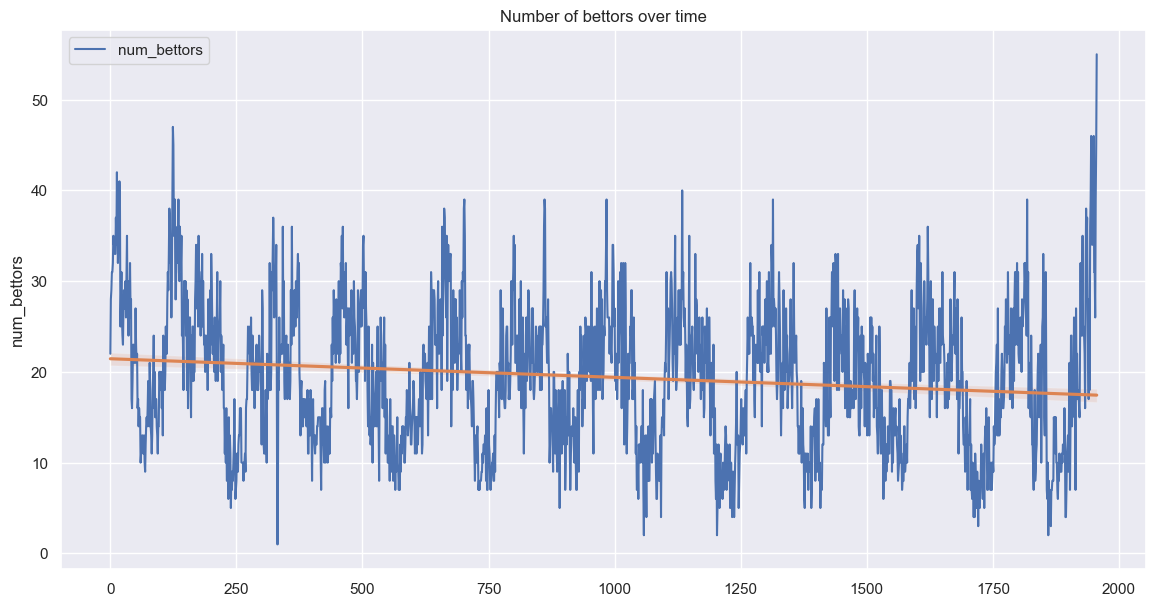

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
# sns.kdeplot(y=data.num_bettors)
plt.show()

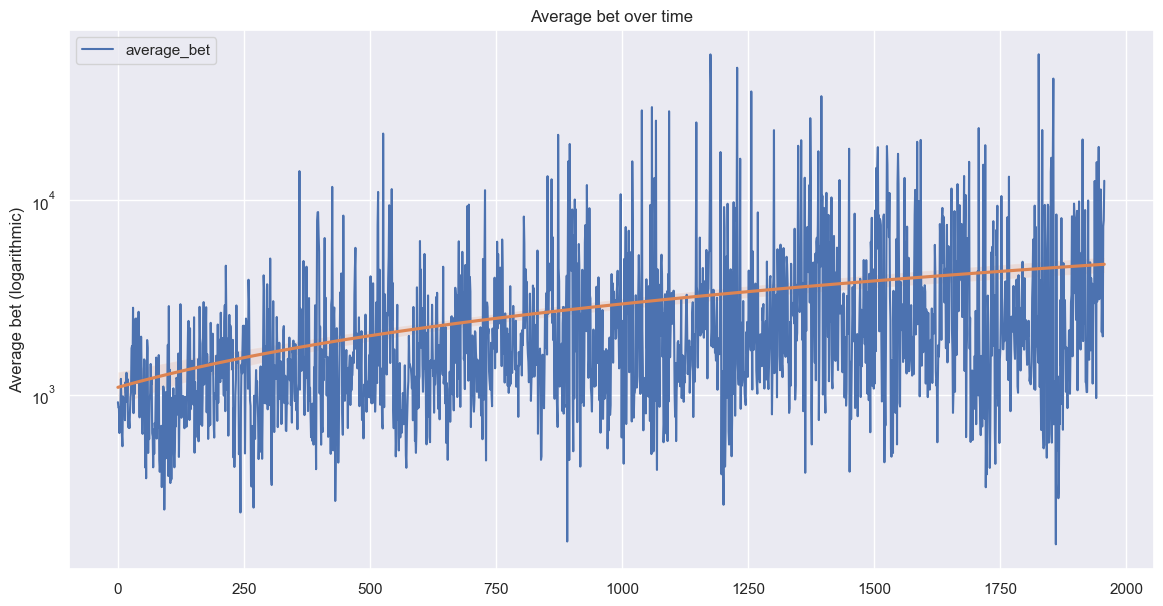

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

<Figure size 640x480 with 0 Axes>

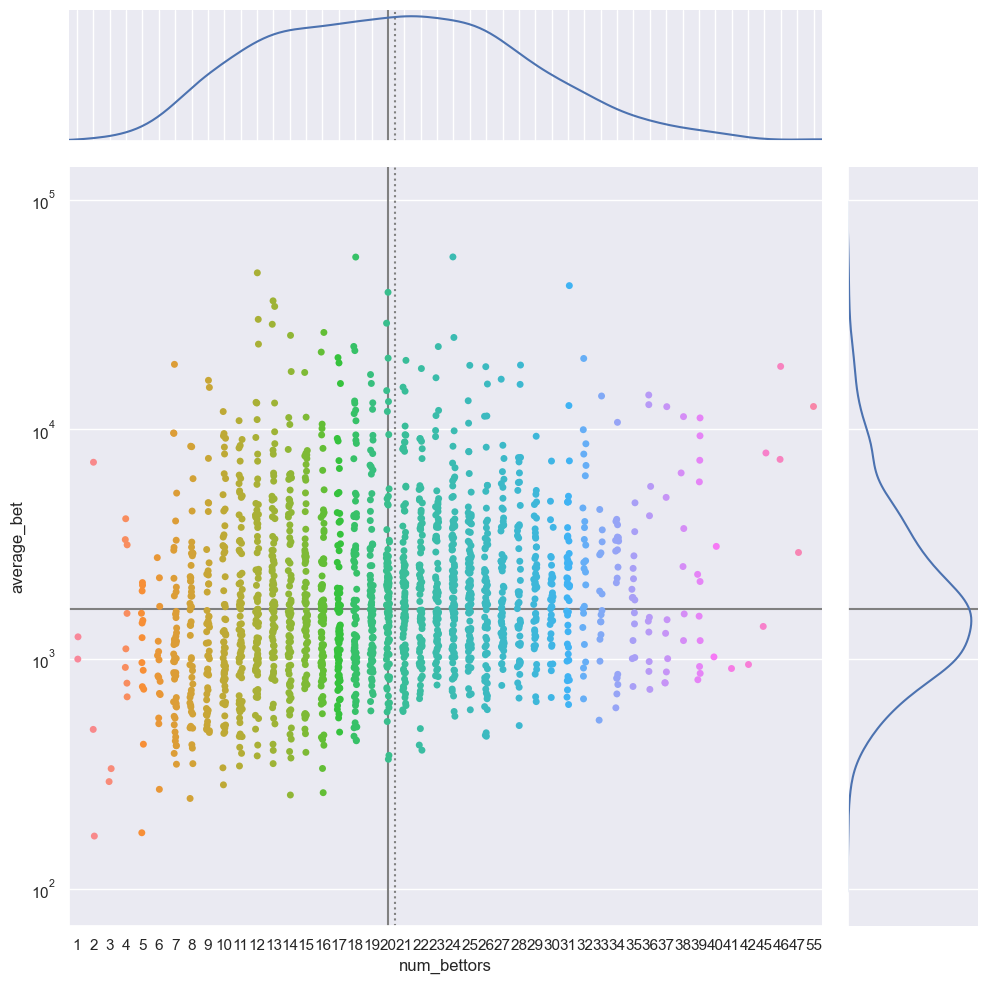

<Figure size 640x480 with 0 Axes>

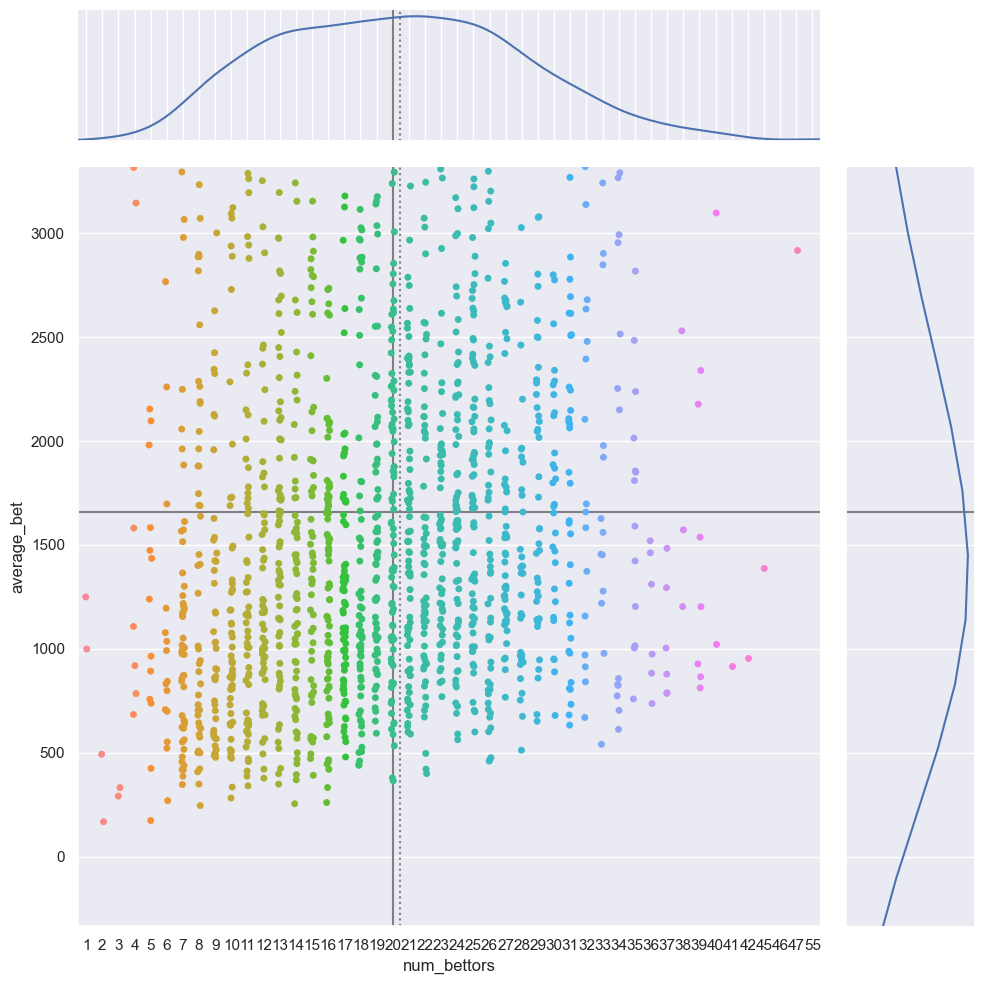

In [10]:
def fill_plot():
    g.refline(x=x.mean(), linestyle=":")
    g.refline(x=x.median(), y=y.median(), linestyle="-")
    sns.stripplot(x=x, y=y, s=5, ax=g.ax_joint)
    sns.kdeplot(x=x, ax=g.ax_marg_x)
    sns.kdeplot(y=y, ax=g.ax_marg_y)
    plt.xticks(rotation=90)
    
x, y = nonzero_bets.num_bettors, nonzero_bets.average_bet

f = plt.figure()
g = sns.JointGrid(x=x, y=y,
                   xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                   height=10,
                  )
g.ax_joint.set_yscale("log")
fill_plot()

median_thresh = y.median() * 2
if(y.max() > median_thresh * 10):
    f = plt.figure()
    g = sns.JointGrid(x=x, y=y,
                    xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                    height=10,
                    ylim=((-0.1*median_thresh),median_thresh)
                  )
    fill_plot()

plt.show()

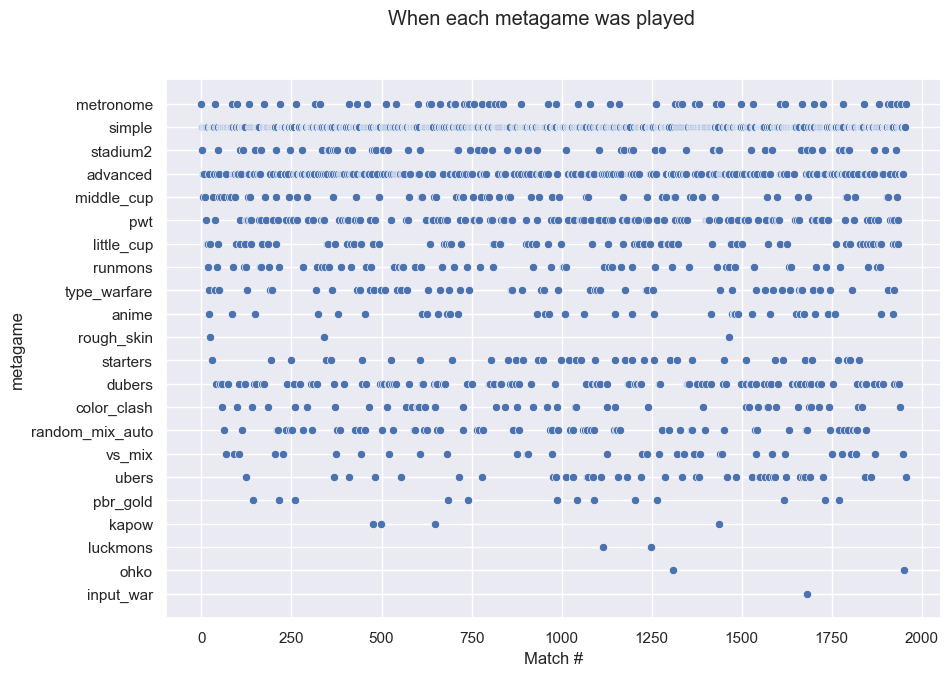

In [11]:
f = plt.figure(figsize=(10,7))
f.suptitle("When each metagame was played")
ax = sns.scatterplot(x=data.index,y=data.metagame)
ax.set(xlabel="Match #")
plt.show()

# Metagames

## Setup

In [12]:
threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
metagames = nonzero_bets.metagame.unique().tolist()
for m in meta.metagame.unique().tolist():
    metagames.remove(m)
print("removed very rare metagames: " + str(metagames))

removed very rare metagames: ['rough_skin', 'kapow', 'luckmons', 'ohko', 'input_war']


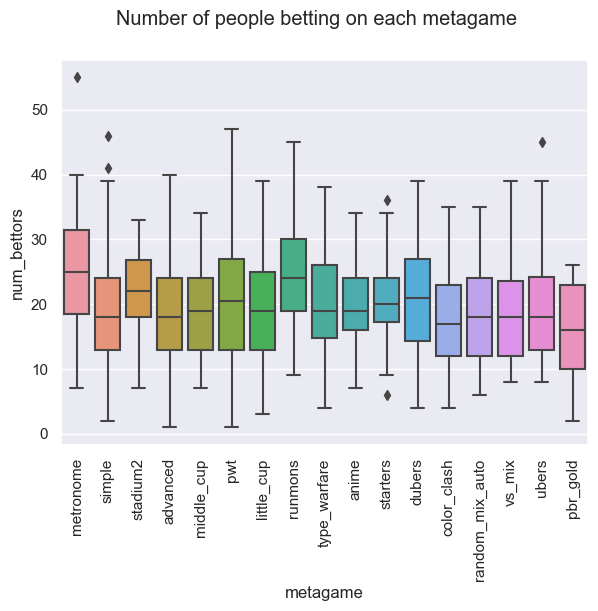

In [13]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Number of people betting on each metagame")
sns.boxplot(x=meta.metagame, y=meta.num_bettors)
plt.xticks(rotation=90)
plt.show()

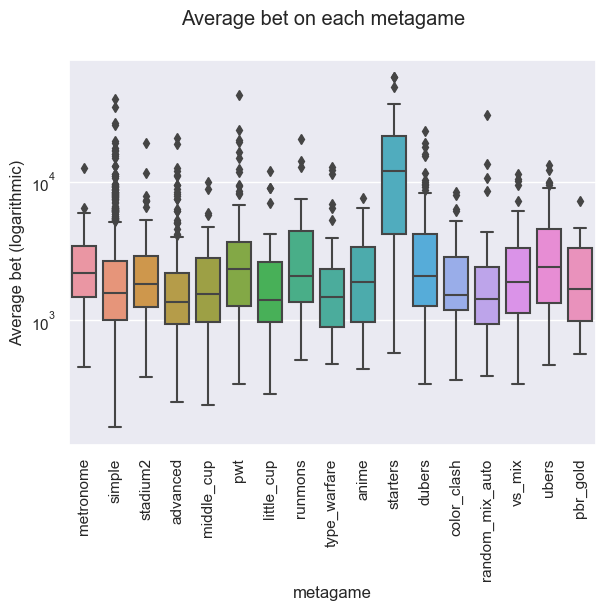

In [14]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Average bet on each metagame")
ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.xticks(rotation=90)
plt.show()

# Gimmicks

## Setup

In [15]:
threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
gimmicks = data.gimmick.unique().tolist()
for g in gim.gimmick.unique().tolist():
    gimmicks.remove(g)
print("removed infrequently used gimmicks: " + str(gimmicks))

removed infrequently used gimmicks: ['doubles_inputting_combo_of_3', 'rngod', 'hit_and_run', 'rainbow', 'afflicted', 'doubles_inputting_combo_of_4', 'spanish', 'letdown', 'sketchy', 'armor', 'hidden_ace', 'french', 'japanese', 'fire_and_ice', 'boing', 'italian', 'shield', 'german', 'doubles_defiance_combo_of_4']


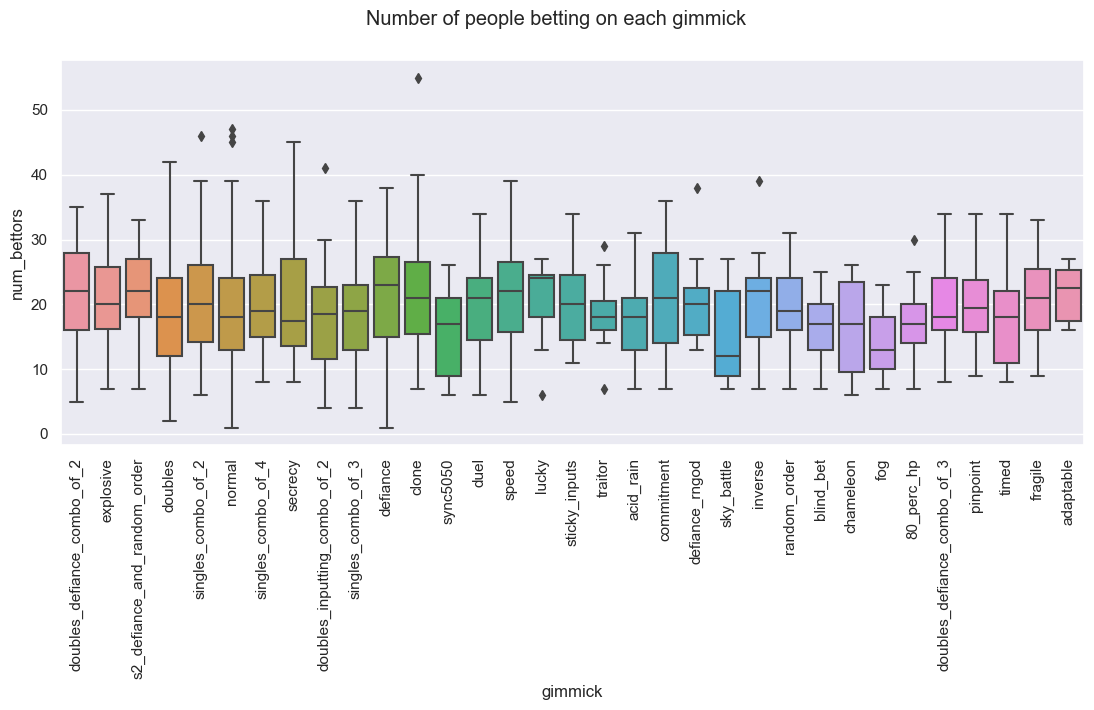

In [16]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Number of people betting on each gimmick")
sns.boxplot(x="gimmick",y="num_bettors",data=gim)
plt.xticks(rotation=90)
plt.show()

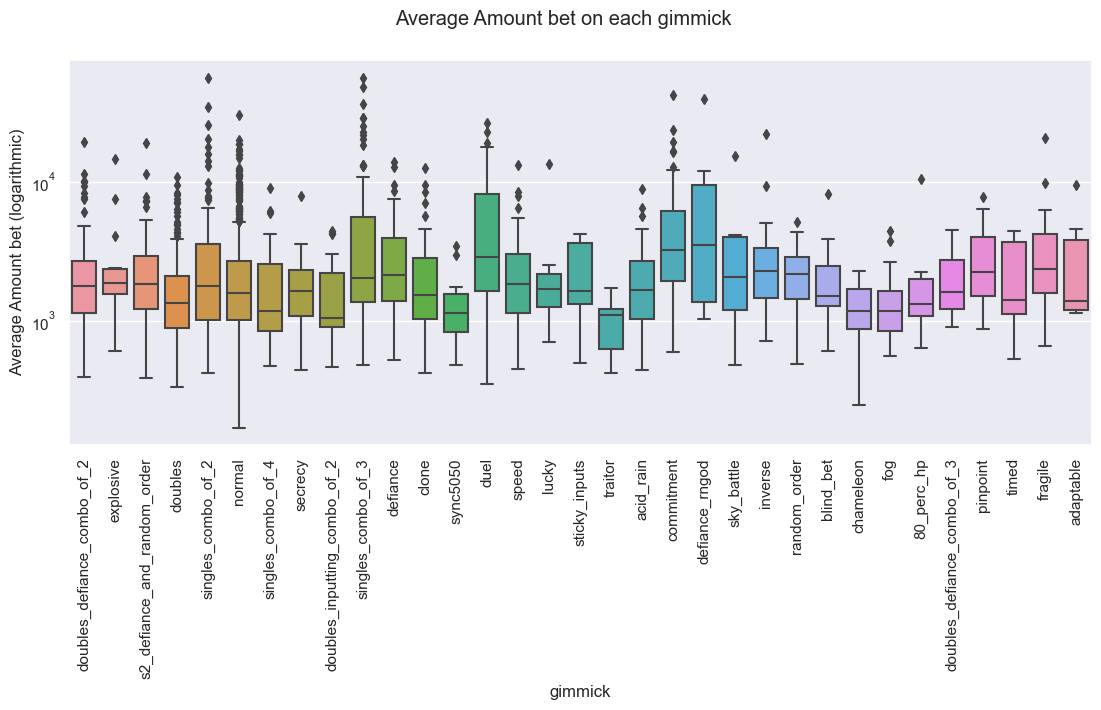

In [17]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Average Amount bet on each gimmick")
ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
plt.xticks(rotation=90)
plt.show()

# Switching

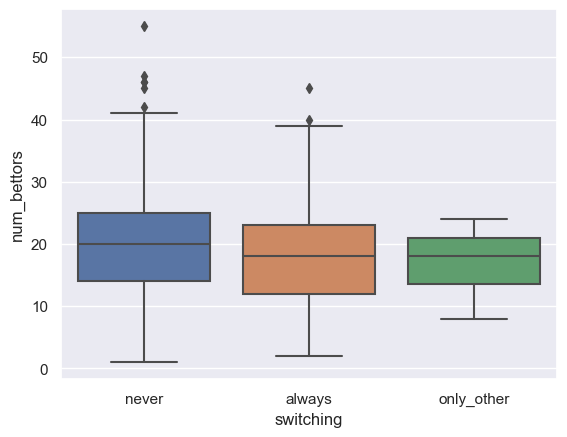

In [18]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

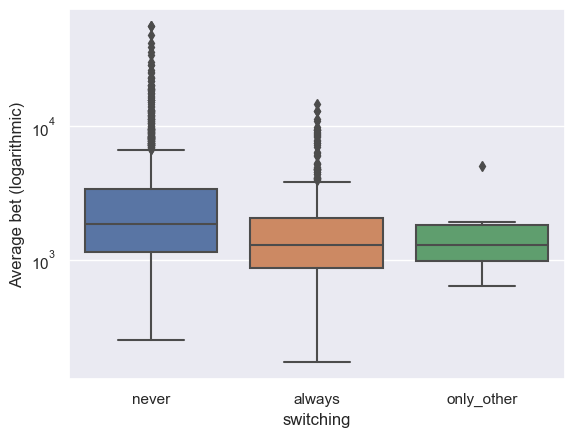

In [19]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

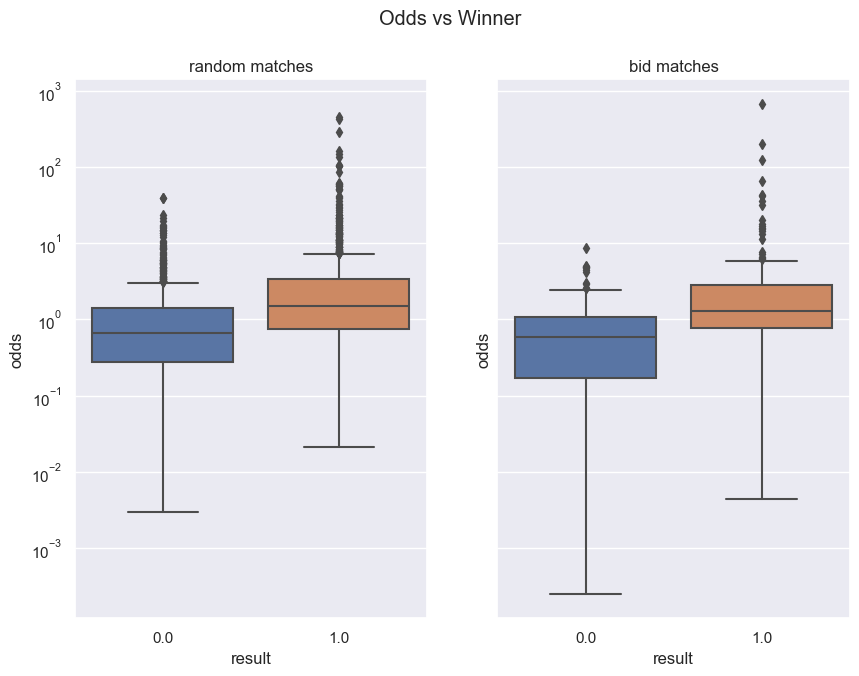

In [20]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

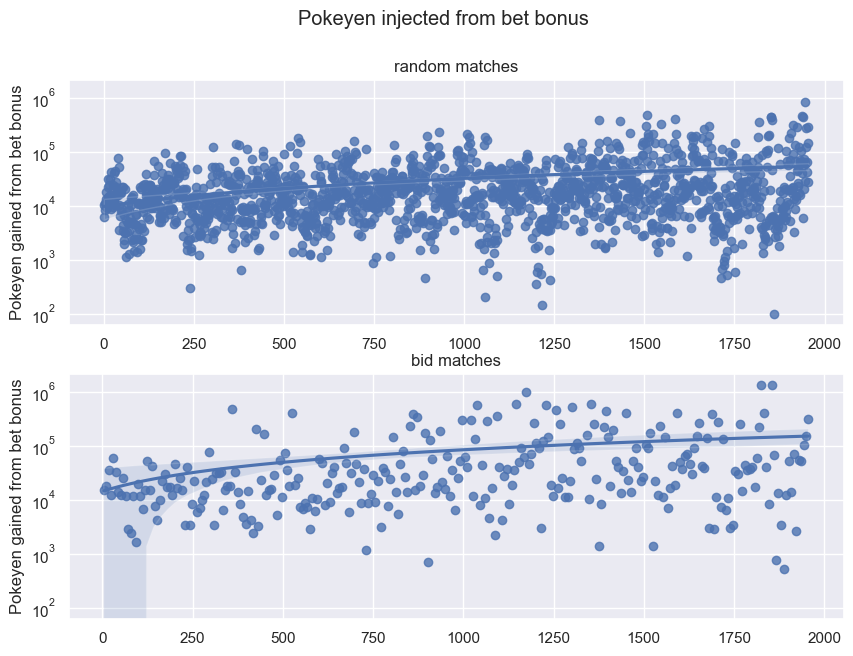

In [21]:
f, ax = plt.subplots(2, 1, figsize=(10,7),sharey=True)
f.suptitle("Pokeyen injected from bet bonus")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[0])
sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount)

ax[0].set(ylabel="Pokeyen gained from bet bonus")
ax[1].set(ylabel="Pokeyen gained from bet bonus")

plt.show()

# Match predictability

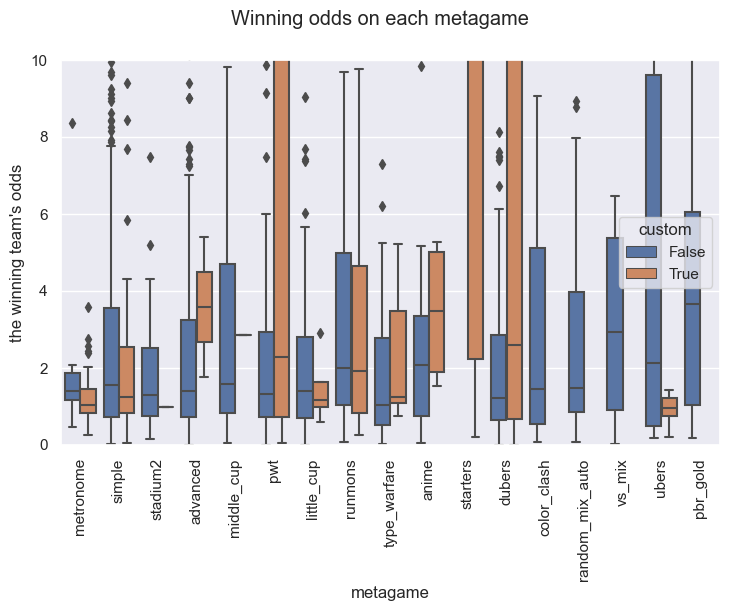

In [22]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2,5))
f.suptitle("Winning odds on each metagame")
ax = sns.boxplot(x=meta.metagame,y=meta.winner_odds, hue=meta.custom)
ax.set(ylabel="the winning team's odds", ylim=(0,10))
plt.xticks(rotation=90)
plt.show()

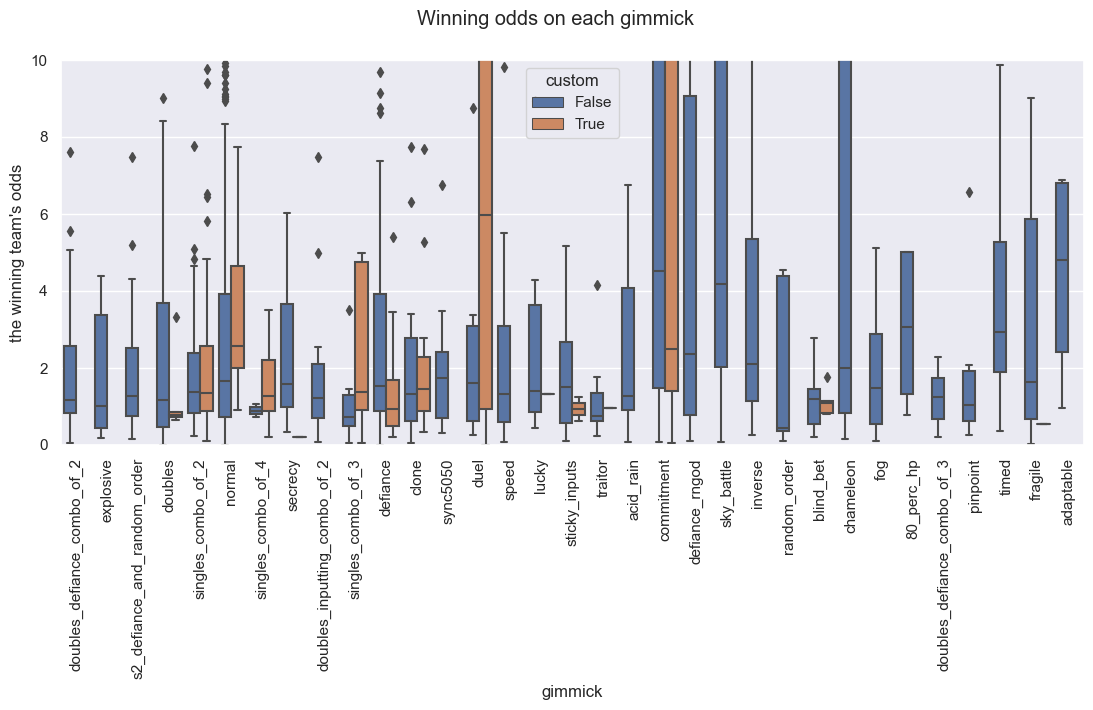

In [23]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Winning odds on each gimmick")
ax = sns.boxplot(x=gim.gimmick,y=gim.winner_odds, hue=gim.custom)
ax.set(ylabel="the winning team's odds", ylim=(0,10))
plt.xticks(rotation=90)
plt.show()